In [1]:
import math 
import random 
import numpy
import matplotlib.pyplot as plt

In [2]:
# Example of random sample method
random.sample(range(5), 2)  # Picks two random UNIQUE numbers from a set of numbers -- use this for swap

[1, 3]

In [3]:
# Draws random number between 0 and 1 -- use for probability of accepting worse route
random.random()

0.8590188541263042

In [47]:
def simulated_annealing_tsp(cities, distances, energy_method = 'log' ,
                            T=1000, T_min=1e-3, alpha=0.9, max_iter=100000):
    """
    Solves the Traveling Salesman Problem (TSP) using Simulated Annealing.

    Parameters:
        cities (list of str): List of city names.
        distances (list or array-type): 2D list (matrix) of distances between cities.
        energy_method (str): Transformation method. Options: 'log', 'square', 'sqrt', 'linear'.
        T (float, optional): Initial temperature for annealing.
        T_min (float, optional): Minimum temperature to stop the process.
        alpha (float, optional): Cooling rate (should be close to 1, e.g., 0.995).
        max_iter (float, optional): Maximum allowed number of iterations.

    Returns:
        best_route (list of str): List of city names representing the best route found.
        best_distance (float): Total distance of the best route.
        temperature_at_best (float): Temperature at which the best route was found.
        temperatures (list of float): Temperatures at each iteration.
        distances_over_time (list of float): Total route distance at each iteration.
        acceptance_pressures (list of float): Acceptance probabilities (exp(-ΔE / T)) for worse moves.
        pressure_temperatures (list of float): Temperatures corresponding to each acceptance probability value.

    """
    n = len(cities)  # Number of cities
    city_indices = list(range(n))  # City indices [0, 1, 2, ..., n-1]

    # --- Helper Functions ---

    def route_distance(route_indices): ### COST FUNCTION 
        """
        Calculates the total distance of a given route (list of city indices),
        including the return trip back to the starting city.
        
        Parameters:
            route_indices (list of int): List of city indices representing the route.

        Returns:
            float: Total distance of the route, including the return trip to the starting city.
        """
        return sum(distances[route_indices[i]][route_indices[i + 1]] for i in range(n - 1)) \
               + distances[route_indices[-1]][route_indices[0]] # Adds distance from last city to start city

    def propose_new_route(route):
        """
        Proposes a neighboring route by swapping two randomly selected cities.
        
        Parameters: 
            route (list of int): Current route represented as a list of city indices.

        Returns:
            (list of int): New route with two cities swapped.
        """
        new_route = route.copy()  # Copy in case we reject new route
        i, j = random.sample(range(n), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]
        return new_route
    
    def compute_energy(cost, method = "log"): 
        """
        Transforms a raw cost into an 'energy' value based on the chosen method. 
        
        Parameters: 
            cost (float): The raw cost value (ie. route distance).
            method (str): Transformation method. Options: 'log', 'square', 'sqrt', 'linear'.
            
        Returns: 
            float: The transformed energy value. 
        """
        if method == 'log': 
            return math.log(cost)
        elif method == 'square': 
            return cost**2
        elif method == 'sqrt':
            return math.sqrt(cost)
        elif method == 'linear':
            return cost
        else: 
            raise ValueError(f"Unspported energy method: {method}")

    # --- Initialization ---

    current_route = city_indices.copy()  
    random.shuffle(current_route)  # Start with a random route
    current_distance = route_distance(current_route)  # Cost / "energy" of initial solution

    # Best known solution
    best_route = current_route.copy()  # Assume for now that first route is best
    best_distance = current_distance   # Update if we find better values of distance
    temperature_at_best = T  # T0, update if we find better routes during cooling step
    
    # For plotting
    iteration = 0  # might be useful to keep track of for plotting later
    temperatures = []
    distances_over_time = []
    acceptance_pressures = []
    pressure_temperatures = []

    # --- Main Annealing Loop ---

    while T > T_min and iteration < max_iter:
        iteration += 1
        temperatures.append(T)
        distances_over_time.append(current_distance)

        # Propose a new route by swapping two cities
        candidate_route = propose_new_route(current_route)
        candidate_distance = route_distance(candidate_route)
        
        # Energy cost function
        current_energy = compute_energy(current_distance, energy_method)
        candidate_energy = compute_energy(candidate_distance, energy_method)

        # Calculate energy difference
        #delta_E = candidate_distance - current_distance
        delta_E = candidate_energy - current_energy

        # Apply Metropolis acceptance rule, check if new state has higher or lower energy
        if delta_E < 0:
            # Better solution: accept automatically
            current_route = candidate_route
            current_distance = candidate_distance
        else:
            # Worse solution: accept with a certain probability (more exploration at higher T)
            acceptance_probability = math.exp(-delta_E / T)
            acceptance_pressures.append(acceptance_probability)  # Keep track of how exploratory/conservative algorithm is behaving during cooling
            pressure_temperatures.append(T)  # Temperatures when worse move is evaluated 
            
            if random.random() < acceptance_probability:
                current_route = candidate_route
                current_distance = candidate_distance
            # Else reject move and stay with the current route

        # Update the best solution found so far
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = current_route.copy()
            temperature_at_best = T

        # Cool down the system
        T *= alpha

    # --- Wrap-up ---

    # Convert best route from indices back to city names
    best_route_named = [cities[idx] for idx in best_route] + [cities[best_route[0]]]

    return best_route_named, best_distance, temperature_at_best, temperatures, distances_over_time, acceptance_pressures, pressure_temperatures


In [101]:
def compare_energy_methods_plot(cities, distances, energy_methods=None, colors=None):
    """
    Compare different energy transformation methods used in simulated annealing
    by plotting:
      - Total cost function vs. temperature
      - Acceptance probability vs. temperature

    Parameters:
        cities (list of str): List of city names.
        distances (2D list of float): Distance matrix.
        energy_methods (list of str): Energy transformation method names.
        colors (list of str): Optional colors for each method.

    Returns:
        None. Displays a matplotlib figure with two subplots.
    """
    if energy_methods is None:
        energy_methods = ['log', 'square', 'sqrt', 'linear']
    
    if colors is None:
        colors = ['blue', 'green', 'orange', 'red']  # default color set

    plt.figure(figsize=(8, 6))

    # Subplot 1: Route distance vs temperature
    plt.subplot(2, 1, 1)
    for method, color in zip(energy_methods, colors):
        random.seed(42)  # Fix seed for reproducibility
        _, _, _, temps, dists, _, _ = simulated_annealing_tsp(
            cities, distances, energy_method=method
        )
        plt.plot(temps, dists, label=method, color=color, lw=1)

    plt.gca().invert_xaxis()
    plt.xlabel("Temperature")
    plt.ylabel("Cost")
    plt.title("Route Distance vs Temperature for Different Energy Models")
    plt.grid(True)
    plt.legend(title="Energy Method")

    # Subplot 2: Acceptance probability vs temperature
    plt.subplot(2, 1, 2)
    for method, color in zip(energy_methods, colors):
        random.seed(42)
        _, _, _, _, _, acc_probs, acc_temps = simulated_annealing_tsp(
            cities, distances, energy_method=method
        )
        plt.plot(acc_temps, acc_probs, label=method, color=color, lw=1)

    plt.gca().invert_xaxis()
    plt.xlabel("Temperature")
    plt.ylabel("Acceptance Probability (exp(−ΔE / T))")
    plt.title("Metropolis Acceptance Probability vs Temperature")
    plt.grid(True)
    plt.legend(title="Energy Method")

    plt.tight_layout(pad=2.0)  # Add space between the two subplots
    plt.show()


In [102]:
cities = ['Strasbourg', 'Nancy', 'Paris', 'Mulhouse', 'Dijon', 'Besancon']
distances = [
    [0, 116, 398, 97, 245, 197],
    [116, 0, 281, 136, 174, 163],
    [398, 281, 0, 389, 263, 327],
    [97, 136, 389, 0, 178, 114],
    [245, 174, 263, 178, 0, 75],
    [197, 163, 327, 114, 75, 0]
]

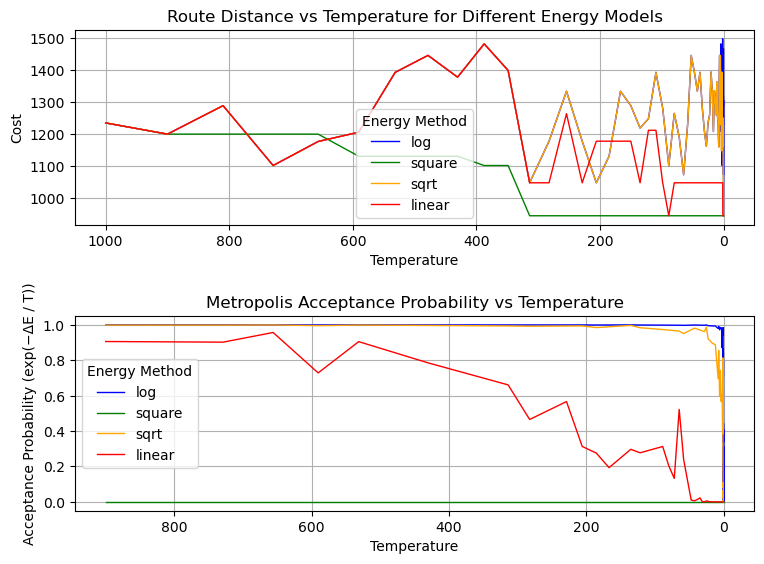

In [103]:
# Compare cost functions and overlay 
compare_energy_methods_plot(cities, distances)

In [113]:
# Individual test

random.seed(42)  # fix to compare against results from above 

method = 'square'  # Cost function 

best_route, best_distance, temp_at_best, temperatures, distances_over_time, \
acceptance_pressures, pressure_temperatures= simulated_annealing_tsp(cities, distances, energy_method=method)

print("Optimal Route:", " -> ".join(best_route))
print(f"Total Distance: {best_distance:.2f} km")
print(f"Found at Temperature: {temp_at_best:.4f}")


Optimal Route: Strasbourg -> Nancy -> Paris -> Dijon -> Besancon -> Mulhouse -> Strasbourg
Total Distance: 946.00 km
Found at Temperature: 348.6784


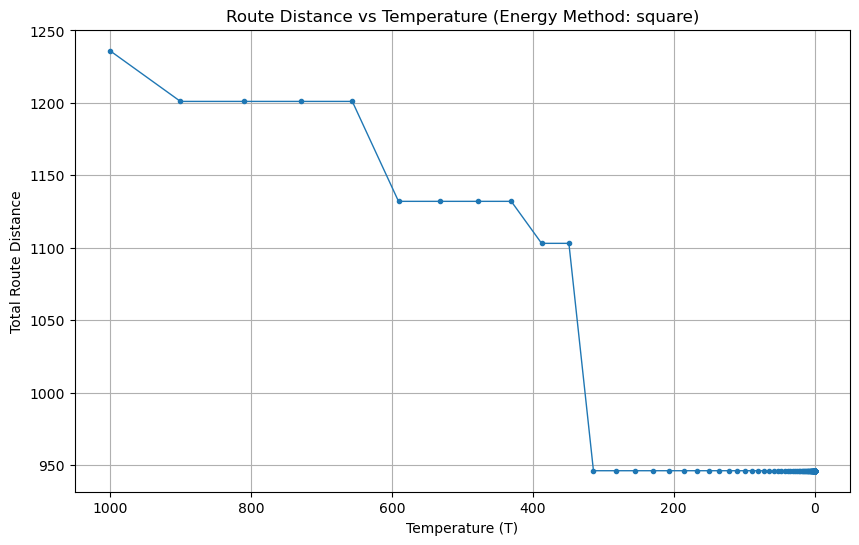

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, distances_over_time, marker='o', markersize=3, linewidth=1)
plt.xlabel('Temperature (T)')
plt.ylabel('Total Route Distance')
plt.title(f'Route Distance vs Temperature (Energy Method: {method})')
plt.gca().invert_xaxis()  # Optional: makes temperature appear high → low left to right
plt.grid(True)
plt.show()

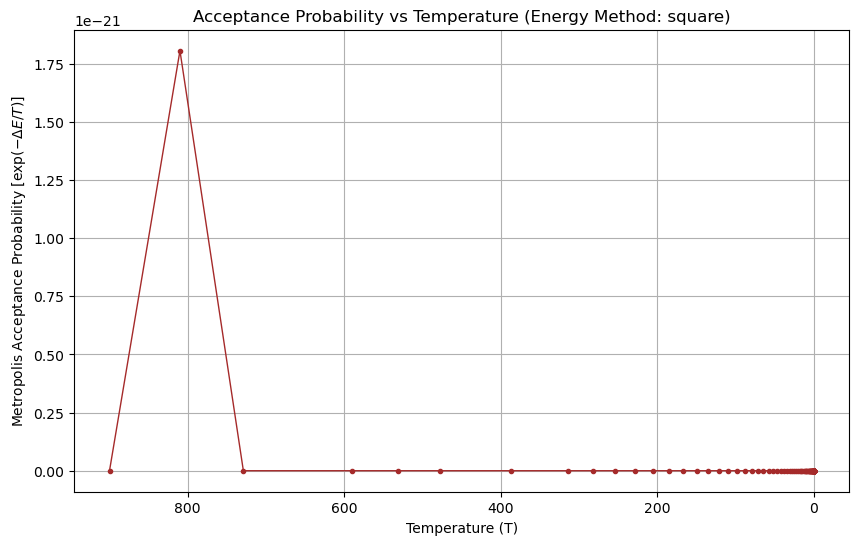

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(pressure_temperatures, acceptance_pressures, marker='o', markersize=3, linewidth=1, color = 'brown')
plt.xlabel('Temperature (T)')
plt.ylabel('Metropolis Acceptance Probability ' r'[$\exp(-\Delta E / T)$]')
plt.title(f"Acceptance Probability vs Temperature (Energy Method: {method})")
plt.gca().invert_xaxis()  # Optional: makes temperature appear high → low left to right
plt.grid(True)
plt.show()